In [244]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import mwtab
import numpy as np

In [260]:
# Import data from MWB 
for mwfile in mwtab.read_files("624"):
    print("ANALYSIS_ID:", mwfile.analysis_id)
    print("SOURCE:", mwfile.source)
    print("Blocks:", list(mwfile.keys()))

# Get the feature table
feature_table_ordered_dict = mwfile['MS_METABOLITE_DATA']['MS_METABOLITE_DATA_START']['DATA']
#print feature_table_dict[22]

feature_dict = {i['metabolite_name']: i for i in feature_table_ordered_dict}

df_feature_table = pd.DataFrame(feature_dict).drop('metabolite_name').astype('float64')

('ANALYSIS_ID:', None)
('SOURCE:', 'http://www.metabolomicsworkbench.org/rest/study/analysis_id/AN000624/mwtab/txt')
('Blocks:', ['METABOLOMICS WORKBENCH', 'PROJECT', 'STUDY', 'SUBJECT', 'SUBJECT_SAMPLE_FACTORS', 'COLLECTION', 'TREATMENT', 'SAMPLEPREP', 'CHROMATOGRAPHY', 'ANALYSIS', 'MS', 'MS_METABOLITE_DATA', 'METABOLITES'])


In [261]:
# Rename the columns with the full m/z and rt values from
# the mapping

df_feature_table.head()
# Get mz/rt for each feature (some are named and don't have the info)

,0.82_611.31,0.91_257.98,0.92_367.1,0.9_550.33,1.01_418.25,1.02_141.1,1.02_462.27,1.05_764.57,1.09_391.28,1.16_694.41,...,C50H76NO8P,C50H80NO8P,C7H8N2O,Glutamine,Methionine,PC 38:7,PE (38:4) [M+H]+,Phenylalanine,Pyroglutamic acid,Tryptophan
LungNodule_10,3955.0,19364.0,113730.0,6516.0,3168.0,3391.0,4188.0,122854.0,59971.0,9079.0,...,166988.0,63353.0,436064.0,635855.0,196863.0,380479.0,21037.0,1430124.0,329338.0,333793.0
LungNodule_100,4581.0,31619.0,108604.0,6044.0,4692.0,3523.0,5139.0,162395.0,54372.0,14804.0,...,194753.0,54989.0,189132.0,421314.0,186399.0,400739.0,34141.0,1903821.0,215214.0,462696.0
LungNodule_101,4466.0,18807.0,40924.0,17428.0,3895.0,4139.0,4917.0,119327.0,3200.0,10464.0,...,167036.0,55946.0,134444.0,470240.0,95945.0,417411.0,50114.0,717701.0,230394.0,165949.0
LungNodule_102,4183.0,9549.0,12595.0,5093.0,4879.0,4570.0,5434.0,112144.0,99497.0,19333.0,...,219523.0,71724.0,128006.0,95377.0,65083.0,397142.0,115404.0,847643.0,46293.0,128660.0
LungNodule_103,4056.0,10337.0,13893.0,6247.0,4652.0,4277.0,5762.0,116710.0,8897.0,13677.0,...,220858.0,71374.0,168093.0,151446.0,87363.0,384146.0,106023.0,982240.0,71190.0,134798.0


In [262]:
# Get a mapping between feature table columns 
# and the accurate mz and rt features
mzrt_to_sample_name_list = mwfile['METABOLITES']['METABOLITES_START']['DATA']
mzrt_sample_map = {i['metabolite_name']: {'mz': i['row m/z'], 
                        'rt': i['row retention time']}
                   for i in mzrt_to_sample_name_list
}

mzrt_sample_map = pd.DataFrame(mzrt_sample_map, dtype='float64')
mzrt_sample_map

,0.82_611.31,0.91_257.98,0.92_367.1,0.9_550.33,1.01_418.25,1.02_141.1,1.02_462.27,1.05_764.57,1.09_391.28,1.16_694.41,...,C50H76NO8P,C50H80NO8P,C7H8N2O,Glutamine,Methionine,PC 38:7,PE (38:4) [M+H]+,Phenylalanine,Pyroglutamic acid,Tryptophan
mz,611.3075,257.9809,367.0952,550.3318,418.2492,141.1008,462.2728,764.5741,391.2835,694.4058,...,856.5827,854.5694,137.0707,147.0769,150.0564,804.5544,768.5501,166.0861,130.0497,205.097
rt,0.8200,0.9100,0.9200,0.9000,1.0100,1.0200,1.0200,1.0500,1.0900,1.1600,...,3.8600,3.8300,6.3200,6.3200,4.6300,3.9700,2.6100,4.2300,6.3300,4.120


In [263]:
# Get metadata in a good format
# (A map between sample names and classes)
sample_factors = mwfile['SUBJECT_SAMPLE_FACTORS']['SUBJECT_SAMPLE_FACTORS']

sample_factors[0]
sample_factor_dict = {i['local_sample_id']: i for i in sample_factors}
# convert 'factors' into actually useful shit.
print pd.DataFrame(sample_factor_dict).index

for key in sample_factor_dict.keys():
    #print sample_factor_dict[key]
    a = sample_factor_dict[key]['factors']
    # split by class
    factor_dict = dict([i.split(':') for i in a.split(' | ')])
    # add all the factors as their own entries in the dict
    for key2 in factor_dict.keys():
        sample_factor_dict[key][key2] = factor_dict[key2]
    # add the other factors as their own entries in the dict
    b = sample_factor_dict[key]['additional_sample_data']
    factor_dict = dict([i.split('=') for i in b.split('; ')])
    for key2 in factor_dict.keys():
        sample_factor_dict[key][key2] = factor_dict[key2]
        


df_metadata = pd.DataFrame(sample_factor_dict).drop('factors').drop('additional_sample_data').T
df_metadata.head()

Index([u'additional_sample_data', u'factors', u'local_sample_id',
       u'subject_type'],
      dtype='object')


,Cancer Type,Emphysema/COPD,Gender,Group,Nodule Classification,Smoking Status,local_sample_id,subject_type
LungNodule_1,N/A,No,Female,Benign,GGO + SN,Former,LungNodule_1,1
LungNodule_10,N/A,Yes,Female,Benign,GGO + SN,Current,LungNodule_10,10
LungNodule_100,adeno 1a,Yes,Male,Cancer,GGO + SN,Former,LungNodule_100,100
LungNodule_101,adeno 1A,No,Female,Cancer,GGO + SN,Former,LungNodule_101,101
LungNodule_102,adeno 1A,Yes,Female,Cancer,GGO + SN,Former,LungNodule_102,102


In [264]:
# Now slice and dice by benign and cancer
print df_metadata['Group'].unique()
print '\nSelection criteria\n', (df_metadata['Group'] == 'Cancer').head()

case = df_metadata[df_metadata['Group'] == 'Cancer'].index
control = df_metadata[df_metadata['Group'] == 'Benign'].index
print 'Case:\n', len(case)
print '\ncontrol:\n', len(control)

['Benign' 'Cancer']

Selection criteria
LungNodule_1      False
LungNodule_10     False
LungNodule_100     True
LungNodule_101     True
LungNodule_102     True
Name: Group, dtype: bool
Case:
65

control:
30


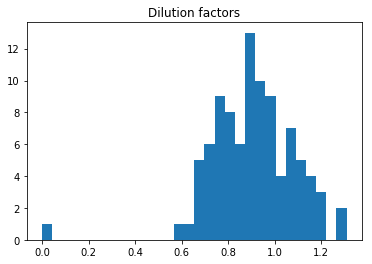

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


In [298]:
# PQN normalize all data
def pqn_normalize(X, plot=True):
    '''
    X can be dataframe
    '''
    X = X.as_matrix()
    #print X
    feature_means = np.mean(X, axis=0)
    # mean-center each feature
    X_mean_centered = np.divide(X, feature_means)
    dilution_factors = np.median(X_mean_centered, axis=1)
    if plot:
        plt.hist(dilution_factors, bins=30)
        plt.title('Dilution factors')
        plt.show()
    # broadcast correctly
    X_pqn = np.divide(X, dilution_factors[:,np.newaxis] )
    return X_pqn

df_pqn_feature_table = pd.DataFrame(pqn_normalize(df_feature_table), 
                                    index=df_feature_table.index,
                                    columns=df_feature_table.columns)

# remove anything that's all inf or nan
df_pqn_feature_table = (df_pqn_feature_table.replace([np.inf, -np.inf], np.nan)
     .dropna(how='all')
                       )


In [349]:
# Mann whitney u-test for all things

df_case_raw = df_feature_table.loc[case]
df_case_pqn = df_pqn_feature_table.loc[case]
df_control_raw = df_feature_table.loc[control]
df_control_pqn = df_feature_table.loc[control]

# Make sure everything's all good
assert(df_case_pqn.columns == df_control_pqn.columns).all()
assert(df_case_raw.columns == df_control_raw.columns).all()


def mann_whitney_df(case, control):
    # TODO - make empirical pvals
    mw_pval = {}
    for col in df_case_pqn.columns:
        u, pval = stats.mannwhitneyu(case[col], control[col])
        mw_pval[col] = pval
    return mw_pval

pval_pqn = pd.Series(mann_whitney_df(df_case_pqn, df_control_pqn), name='pvals_normal')
pval_raw = pd.Series(mann_whitney_df(df_case_raw, df_control_raw), name='pvals_normal')

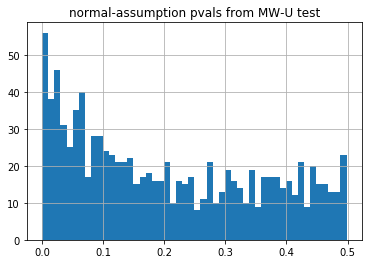

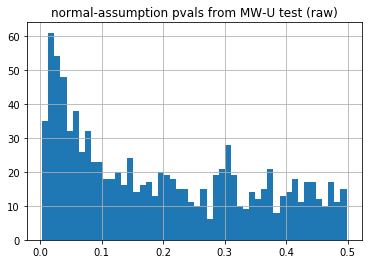

In [350]:
pval_pqn.hist(bins=50)
plt.title('normal-assumption pvals from MW-U test')
plt.show()

pval_raw.hist(bins=50)
plt.title('normal-assumption pvals from MW-U test (raw)')
plt.show()

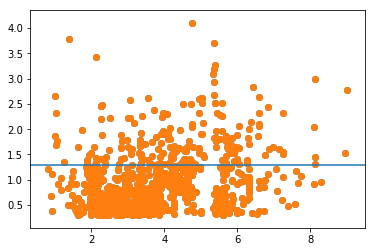

In [348]:
# BH-correct pvals?

# plot pvals vs. rt and dotted line of BH-threshold
pval_pqn
pval_rt =  pd.concat([-np.log10(pval_pqn), mzrt_sample_map.loc['rt']], axis=1)
plt.scatter(x=pval_rt['rt'], y=pval_rt['pvals_normal'])
plt.axhline(-np.log10(0.05))
plt.show()
# Plot mz/rt points with histograms

<h2> Future-self: Update this to get pvals via permutation test (just do 1000 and call it a day? Or more for smaller values? </h2>
But focus on the plot of AUC vs. rt window first! It's the better graphic